<a href="https://colab.research.google.com/github/Winkielek/gflownet/blob/master/notebooks/mols_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone gflownet lib
!rm -rf gflownet
!git clone https://github.com/Winkielek/gflownet.git

# Freeze torch version
!pip install torch==2.1.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html

# Install torch geometric
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-geometric scipy==1.8 deepchem

# Install gflownet lib
!pip install -e ./gflownet

Cloning into 'gflownet'...
remote: Enumerating objects: 1392, done.
remote: Counting objects: 100% (516/516), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 1392 (delta 397), reused 368 (delta 343), pack-reused 876
Receiving objects: 100% (1392/1392), 13.59 MiB | 16.53 MiB/s, done.
Resolving deltas: 100% (774/774), done.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Fo

In [1]:
import os
import shutil
import socket
from typing import Callable, Dict, List, Tuple, Union

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch_geometric.data as gd
from rdkit import Chem
from rdkit.Chem.rdchem import Mol as RDMol
from torch import Tensor
from torch.utils.data import Dataset

from gflownet.config import Config
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext, Graph
from gflownet.models import bengio2021flow
from gflownet.online_trainer import StandardOnlineTrainer
from gflownet.trainer import FlatRewards, GFNTask, RewardScalar
from gflownet.utils.conditioning import TemperatureConditional

import matplotlib.pyplot as plt
import networkx as nx
import deepchem as dc

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [2]:
from gflownet.tasks.seh_frag import SEHFragTrainer

In [3]:
hps = {
    "log_dir": "./logs/debug_run_seh_frag_pb",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "overwrite_existing_exp": True,
    "num_training_steps": 500,
    "num_workers": 2,
    "opt": {
        "lr_decay": 20000,
    },
    "algo": {"sampling_tau": 0.99, "offline_ratio": 0.0},
    "cond": {
        "temperature": {
            "sample_dist": "uniform",
            "dist_params": [0, 64.0],
        }
    },
}
if os.path.exists(hps["log_dir"]):
    if hps["overwrite_existing_exp"]:
        shutil.rmtree(hps["log_dir"])
    else:
        raise ValueError(f"Log dir {hps['log_dir']} already exists. Set overwrite_existing_exp=True to delete it.")
os.makedirs(hps["log_dir"])

trial = SEHFragTrainer(hps)
trial.print_every = 100
# trial.run()



Hyperparameters:

log_dir: ./logs/debug_run_seh_frag_pb
device: cuda
seed: 0
validate_every: 1000
checkpoint_every: null
print_every: 100
start_at_step: 0
num_final_gen_steps: null
num_training_steps: 500
num_workers: 2
hostname: 670b38fa97ca
pickle_mp_messages: false
git_hash: b8cac9b
overwrite_existing_exp: true
algo:
  method: TB
  global_batch_size: 64
  max_len: 128
  max_nodes: 9
  max_edges: 128
  illegal_action_logreward: -75.0
  offline_ratio: 0.0
  valid_offline_ratio: 0.0
  train_random_action_prob: 0.0
  valid_random_action_prob: 0.0
  valid_sample_cond_info: true
  sampling_tau: 0.99
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_sample_p_b: true
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.001
    Z_lr_decay: 50000.0
    cum_subtb: true
  moql:
    gamma: 1.0
    num_omega_samples: 32
    num_objectives: 2
    la

In [4]:
PATH = "./model"

In [ ]:
# torch.save(trial.model.state_dict(), PATH)

In [5]:
model = trial.model
model.load_state_dict(torch.load(PATH))
model = model.to("cuda")

In [6]:
# Trajectories generation

n = 1000
batch_size = 100
num_gen = 0

traj = []
rew = []

while num_gen<n:

    pred = trial.algo.graph_sampler.sample_from_model(
    model,
    batch_size,
    trial.task.sample_conditional_information(batch_size,None)["encoding"].to("cuda"),
    "cuda"
    )

    # Store trajectories
    for p in pred:
        traj.append(p["traj"])
    # Store rewards
    mols = [trial.ctx.graph_to_mol(p["result"])for p in pred]
    rewards = trial.task.compute_flat_rewards(mols)
    rewards = rewards[0].numpy().reshape(-1).tolist()
    rew += rewards
    num_gen += batch_size

In [7]:
# Inverse transformation of rewards
rew = [8*r for r in rew]

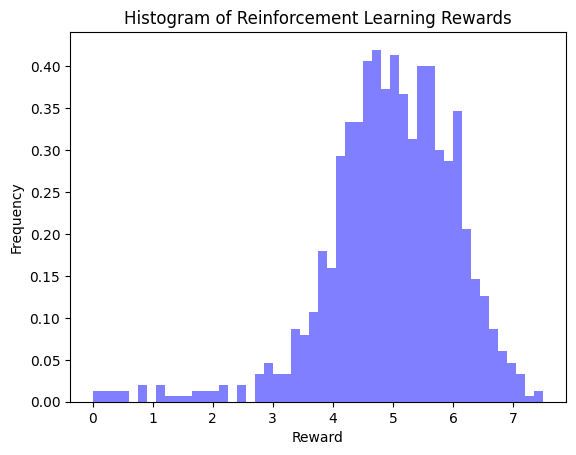

In [8]:
# Create a histogram
plt.hist(rew, bins=50, density=True, alpha=0.5, color='blue')

# Add labels and title
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title('Histogram of Reinforcement Learning Rewards')

# Show the plot
plt.show()

In [9]:
# How does a step of trajectory look like?
traj_id = 10
state = 4
print(traj[traj_id][state])
print(f"Current graph: {traj[traj_id][state][0]}")
cur_action = traj[traj_id][state][1]
print(f"Current action: {cur_action}")
print(f"Action source: {cur_action.source}")
print(f"Action target: {cur_action.target}")
print(f"Action value: {cur_action.value}")

(<[0, 1, 2, 3], [(0, 1), (0, 2), (2, 3)], [7, 7, 12, 30]>, <GraphActionType.AddNode, 0, 11>)
Current graph: <[0, 1, 2, 3], [(0, 1), (0, 2), (2, 3)], [7, 7, 12, 30]>
Current action: <GraphActionType.AddNode, 0, 11>
Action source: 0
Action target: None
Action value: 11


Node 0: C1CCCCC1
Node 1: C1CCCCC1
Node 2: C1CNCCN1
Node 3: CNC=O
Next fragment added: C1CCOCC1


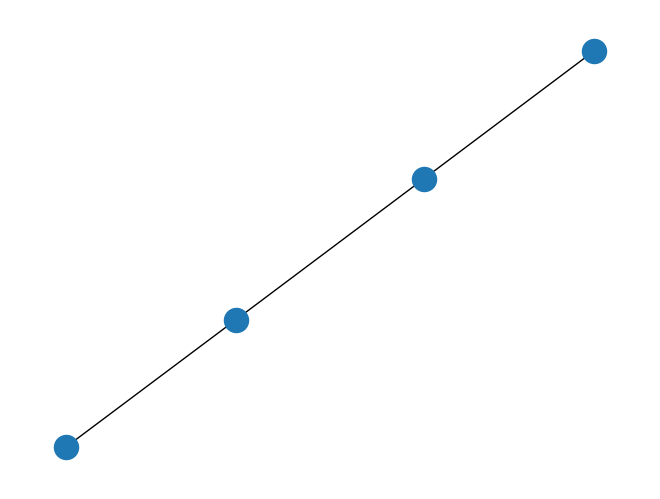

In [12]:
# How do nodes translate to fragments?
g = traj[traj_id][state][0]
for i in g.nodes:
    mol = trial.ctx.frags_mol[g.nodes[i]["v"]]
    mol_smi = trial.ctx.frags_smi[g.nodes[i]["v"]]
    print(f"Node {i}: {mol_smi}")
print(f"Next fragment added: {trial.ctx.frags_smi[cur_action.value]}")
nx.draw(g)

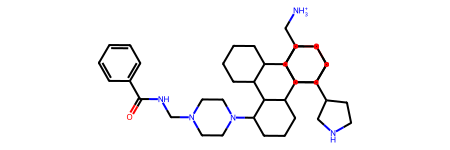

In [13]:
# Output molecule
trial.ctx.graph_to_mol(traj[traj_id][-1][0])

### Trajectories to graphs and molecules features

In [14]:
# Keep only graphs from trajectories
graphs = []

for t in traj:
    cur_act = []
    for step in t:
        cur_act.append(step[0])
    graphs.append(cur_act)

In [15]:
def graph_to_mol(trial_ctx, g: Graph) -> Chem.Mol:
    # Modified to transform also not valid molecules
    """Convert a Graph to an RDKit molecule

    Parameters
    ----------
    g: Graph
        A Graph instance representing a fragment junction tree.

    Returns
    -------
    m: Chem.Mol
        The corresponding RDKit molecule
    """
    offsets = np.cumsum([0] + [trial_ctx.frags_numatm[g.nodes[i]["v"]] for i in g])
    mol = None
    for i in g.nodes:
        if mol is None:
            mol = trial_ctx.frags_mol[g.nodes[i]["v"]]
        else:
            mol = Chem.CombineMols(mol, trial_ctx.frags_mol[g.nodes[i]["v"]])

    mol = Chem.EditableMol(mol)
    bond_atoms = []
    for a, b in g.edges:
        afrag = g.nodes[a]["v"]
        bfrag = g.nodes[b]["v"]
        # if self.fail_on_missing_attr:
        #     assert "src_attach" in g.edges[(a, b)] and "dst_attach" in g.edges[(a, b)]
        u, v = (
            int(trial_ctx.frags_stems[afrag][g.edges[(a, b)].get("src_attach", 0)] + offsets[a]),
            int(trial_ctx.frags_stems[bfrag][g.edges[(a, b)].get("dst_attach", 0)] + offsets[b]),
        )
        bond_atoms += [u, v]
        mol.AddBond(u, v, Chem.BondType.SINGLE)
    mol = mol.GetMol()
    def _pop_H(atom):
        atom = mol.GetAtomWithIdx(atom)
        nh = atom.GetNumExplicitHs()
        if nh > 0:
            atom.SetNumExplicitHs(nh - 1)

    list(map(_pop_H, bond_atoms))
    Chem.SanitizeMol(mol)
    return mol

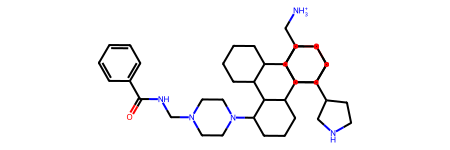

In [16]:
graph_to_mol(trial.ctx, graphs[traj_id][-1])

In [17]:
# Store mol representation on each trajectory step
# If mol is not valid at that step, previous valid is taken
mols = []
valid = []

for t in graphs:
    cur_traj = []
    cur_val = []
    last_val = None
    for g in t[1:]:
        try:
            cur_mol = graph_to_mol(trial.ctx, g)
            cur_traj.append(cur_mol)
            cur_val.append(True)
            last_val = cur_mol
        except:
            cur_val.append(False)
            cur_traj.append(last_val)
    mols.append(cur_traj)
    valid.append(cur_val)

### Check validity of molecules on given step

In [18]:
df_valid = pd.DataFrame(valid)

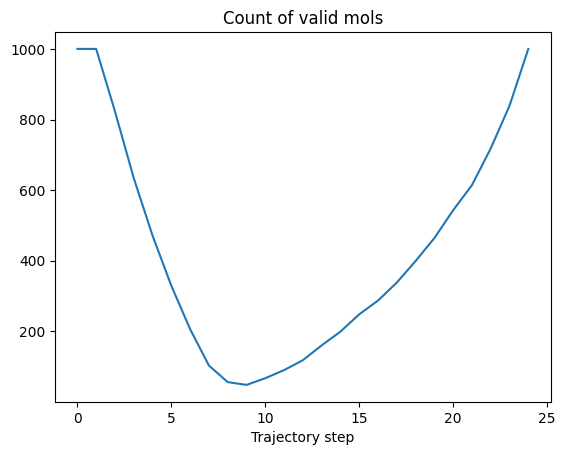

In [19]:
plt.plot(range(len(df_valid.columns)), df_valid.sum())
plt.title("Count of valid mols")
plt.xlabel("Trajectory step")
plt.show()

### Basic graph properties

In [20]:
# Here we can see what attributes are required for each node
graphs[0][-1].edges(data=True)

EdgeDataView([(0, 1, {'src_attach': 2, 'dst_attach': 1}), (0, 3, {'src_attach': 1, 'dst_attach': 0}), (0, 8, {'src_attach': 4, 'dst_attach': 1}), (1, 2, {'dst_attach': 1, 'src_attach': 0}), (2, 6, {'dst_attach': 2, 'src_attach': 2}), (3, 4, {'src_attach': 1, 'dst_attach': 0}), (4, 5, {'src_attach': 1, 'dst_attach': 0}), (6, 7, {'dst_attach': 1, 'src_attach': 3})])

In [21]:
num_edges = []
num_nodes = []
valid_edges = []
for t in graphs:
    e = []
    n = []
    val_e = []
    for g in t:
        n.append(g.number_of_nodes())
        e.append(g.number_of_edges())
        e_cnt = 0
        for u, v, a in g.edges(data=True):
            if ('dst_attach' in list(a.keys())) & ('src_attach' in list(a.keys())):
                e_cnt += 1
        val_e.append(e_cnt)
    valid_edges.append(val_e)
    num_edges.append(e)
    num_nodes.append(n)

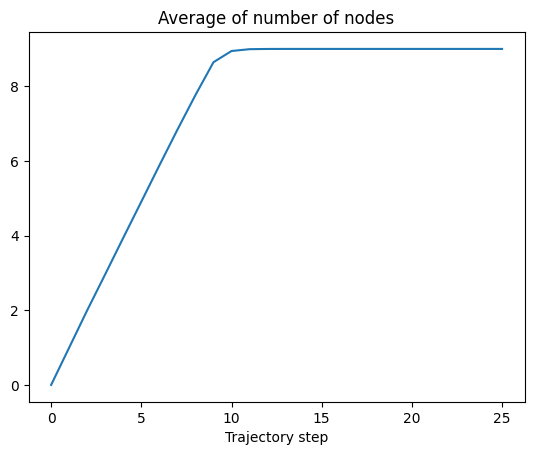

In [22]:
df_nodes = pd.DataFrame(num_nodes)
plt.plot(range(len(df_nodes.columns)), df_nodes.mean())
plt.title("Average of number of nodes")
plt.xlabel("Trajectory step")
plt.show()

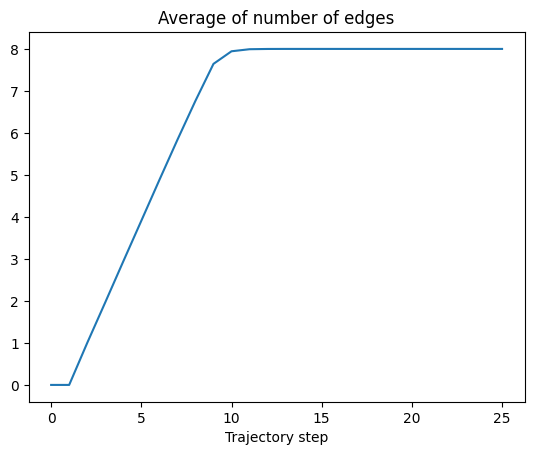

In [23]:
df_edges = pd.DataFrame(num_edges)
plt.plot(range(len(df_edges.columns)), df_edges.mean())
plt.title("Average of number of edges")
plt.xlabel("Trajectory step")
plt.show()

In [24]:
for id, t in enumerate(valid_edges):
    total_edges = t[-1]
    valid_edges[id] = [x/total_edges for x in t]

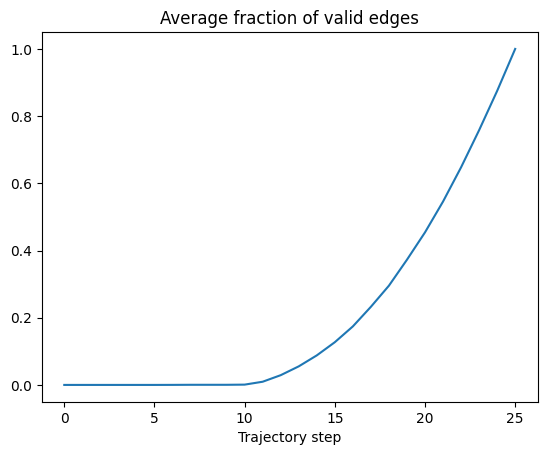

In [25]:
df_val_edges = pd.DataFrame(valid_edges)
plt.plot(range(len(df_val_edges.columns)), df_val_edges.mean())
plt.title("Average fraction of valid edges")
plt.xlabel("Trajectory step")
plt.show()

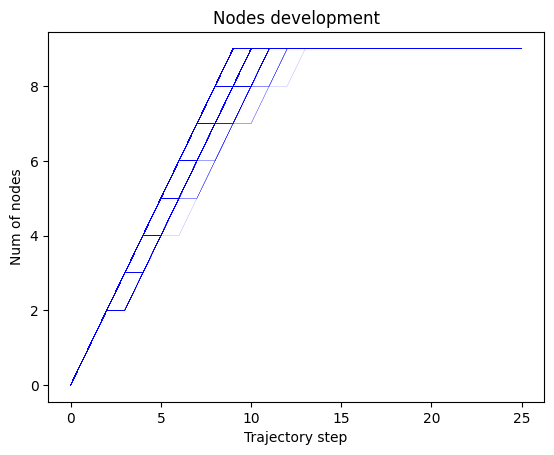

In [26]:
for t in num_nodes:
    plt.plot(range(len(t)), t, color="blue", linewidth=0.1)
plt.title("Nodes development")
plt.xlabel("Trajectory step")
plt.ylabel("Num of nodes")
plt.show()

### Chemical features  
#### Works only for valid molecules. Because of that, on trajectories steps that are not a valid molecule, last valid step from previous ones is taken.
---



In [27]:
# Chem featurizer
feat = dc.feat.RDKitDescriptors()

In [28]:
arr = feat.featurize(mols[traj_id])

In [29]:
# Example of featurized trajectory
pd.DataFrame(arr, columns=feat.descriptors)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1.500000,1.500000,1.500000,1.500000,0.422316,24.000000,84.162,72.066,84.093900,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.560185,1.560185,1.138009,1.138009,0.548757,29.000000,166.308,144.132,166.172151,70.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.532289,3.532289,0.611875,0.611875,0.809577,31.333333,250.430,220.190,250.240899,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.532289,3.532289,0.611875,0.611875,0.809577,31.333333,250.430,220.190,250.240899,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.532289,3.532289,0.611875,0.611875,0.809577,31.333333,250.430,220.190,250.240899,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.532289,3.532289,0.611875,0.611875,0.809577,31.333333,250.430,220.190,250.240899,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,3.532289,3.532289,0.611875,0.611875,0.809577,31.333333,250.430,220.190,250.240899,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.532289,3.532289,0.611875,0.611875,0.809577,31.333333,250.430,220.190,250.240899,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3.532289,3.532289,0.611875,0.611875,0.809577,31.333333,250.430,220.190,250.240899,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3.532289,3.532289,0.611875,0.611875,0.809577,31.333333,250.430,220.190,250.240899,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Featurize data
num_actions = []
for m in mols:
    num_actions.append(feat.featurize(m).tolist())

In [31]:
flat_X = []
flat_y = []
for id, t in enumerate(num_actions):
    actions = traj[id][1:]
    for idx, a in enumerate(t):
        flat_X.append(a)
        flat_y.append(actions[idx][1].action.cname)

In [32]:
df_flat_ = pd.DataFrame(flat_X, columns=feat.descriptors)
df_flat_["target"] = flat_y
print(df_flat_.size)

5275000


In [33]:
# Because of replication of mols for not valid steps there are many duplicates
# We drop them for the classificator experiments
df_flat = df_flat_.drop_duplicates()
print(df_flat.size)

1623645


In [34]:
df_flat.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,5.069444,5.069444,1.000000,1.000000,0.429940,24.000000,86.134,76.054,86.073165,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,add_node
1,9.905150,9.905150,0.637917,0.637917,0.571368,20.400000,143.186,130.082,143.094629,58.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,add_node
2,10.648068,10.648068,0.002407,0.002407,0.759684,19.000000,221.260,206.140,221.116427,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,add_node
3,10.970456,10.970456,0.119167,-0.126366,0.646154,20.052632,261.325,242.173,261.147727,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,add_node
4,11.224001,11.224001,0.273378,-0.338657,0.544919,18.739130,318.377,296.201,318.169191,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,add_node


In [35]:
df_flat["target"].value_counts()

set_edge_attr    4337
add_node         2358
stop             1000
Name: target, dtype: int64

In [36]:
df_flat.to_csv("featurized_mols_actions.csv")